# 5. STDP (Spike-timing-dependent plasticity, 尖峰时间独立可塑性)的无监督学习

**Spike-timing-dependent plasticity:** 根据突触前后细胞的发火时刻差的不同，突出强度产生变化的现象。

典型的STDP为**Pair-based STDP**

根据前后细胞尖峰pair的发火时刻不同，存在**LTP(long-term potentiation, 長期増強)** 或**LTD(long-term depression, 長期抑圧)**


令postsynaptic spike的发生时刻为$t_{post}$, presynaptic spike的发生时刻为$t_{pre}$。差为$\Delta t_{spike}=t_{post}-t_{pre}$

根据 **Pair-based STDP**法则，突触前细胞到后细胞的强度变化$\Delta w$为：

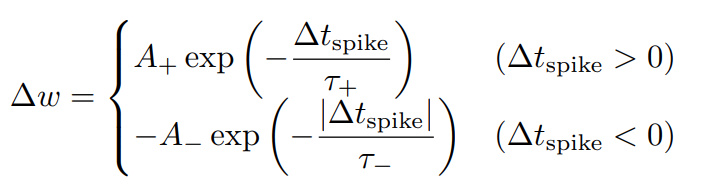


其中$A_+$, $A_-$为正的常数。或是与权重依存的函数。



$\Delta t_{spike}<0$时引起**LTD**。

这样类型的STDP法则也被称为：**Hebbian STDP**

> 长期增强作用（英语：Long-term potentiation，LTP）又称长时程增强作用、长期增益效应，是由于同步刺激两个神经元而发生在两个神经元信号传输中的一种**持久的增强**现象。[2]这是与突触可塑性——突触改变强度的能力相关的几种现象之一。


> LTD 和 LTP 都是突触可塑性的形式。


> 海马体和小脑中的LTD是最好的特征，但还有其他大脑区域可以理解LTD的机制。 [1] LTD也被发现发生在释放各种神经递质的不同类型的神经元中，然而，LTD中最常见的神经递质是L-谷氨酸。

由Hebb則得到突触强度变化:

$A_+ = 0.01, A_-/A_+=1.05,\tau_+=\tau_-=20ms$的情况:

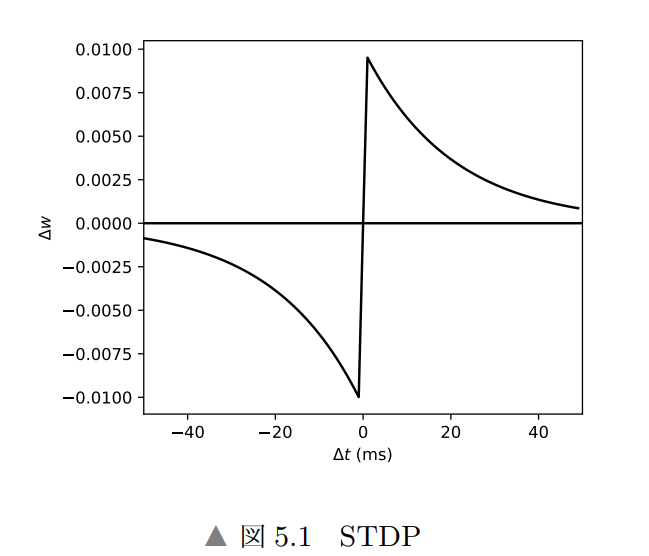

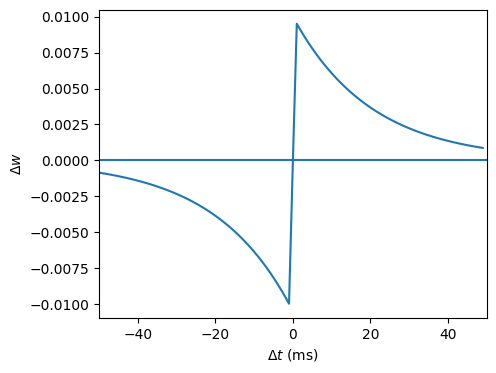

In [1]:
import numpy as np
import matplotlib.pyplot as plt
tau_p = tau_m = 20 #ms
A_p = 0.01
A_m = 1.05*A_p
dt = np.arange(-50, 50, 1) #ms
dw = A_p*np.exp(-dt/tau_p)*(dt>0) - A_m*np.exp(dt/tau_p)*(dt<0)
plt.figure(figsize=(5, 4))
plt.plot(dt, dw)
plt.hlines(0, -50, 50); plt.xlim(-50, 50)
plt.xlabel("$\Delta t$ (ms)"); plt.ylabel("$\Delta w$")
plt.show()

### 5.1.2 Online STDP

如果我们考虑整个网络，上面的方法执行就会变得复杂和低效。

从生物学角度来看，记住尖峰发生的时间也是不恰当的。

**因此，STDP 使用一个局部变量来实现，即尖峰活动轨迹（trace）**

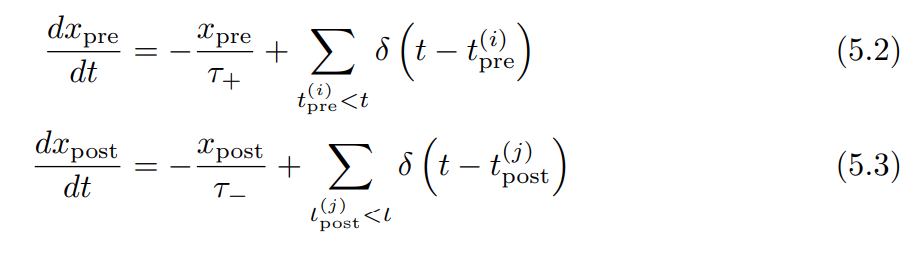

+ $t^{(i)}_{pre}$ 表示突触前细胞的第 $i$ 个尖峰，$t_{post}^{(j)}$ 表示突触后细胞的第 $j$ 个尖峰

$x_{pre}$ 和 $x_{post}$ 分别是突触前细胞和突触后细胞的尖峰轨迹。当每个细胞出现尖峰时，迹线增加 1，
否则以时间常数 $τ_+$ 以及 $τ_-$ 指数递减。这与第一章中描述的单指数突触相同。

其生理学解释是，$x_{pre}$ 是 NMDA 受体离子通道的开放率，$x_{post}$ 是**反向传导动作电位（bAP）** 和由 **bAP** 激活的电压门控 Ca2+ 通道的 Ca2+ 流入量（参见 "标准生理学 "*6）。 

在之后，利用 $x_{pre}$ 和 $x_{post}$，权重更新公式为:

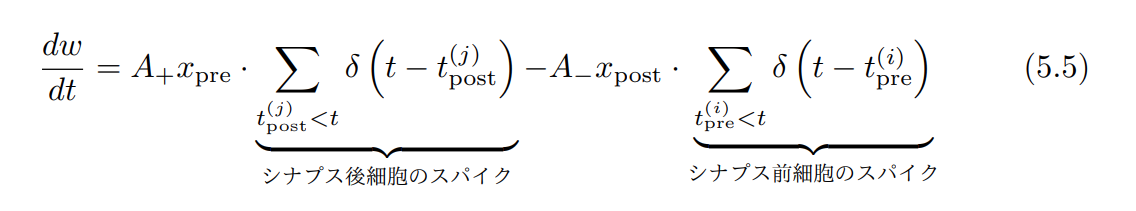

> bAP 是一种从细胞体逆向传播到突触树突的动作电位。它与误差反向传播方法无关。

上式使用Eular法离散化之后：

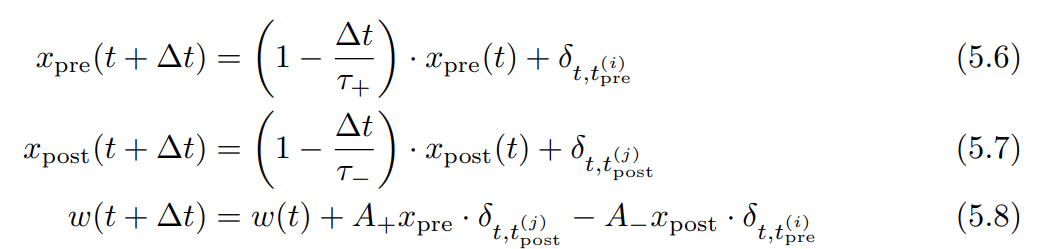

$\delta_{t,t'}$为delta函数，$t=t'$时为1，其余情况为0。

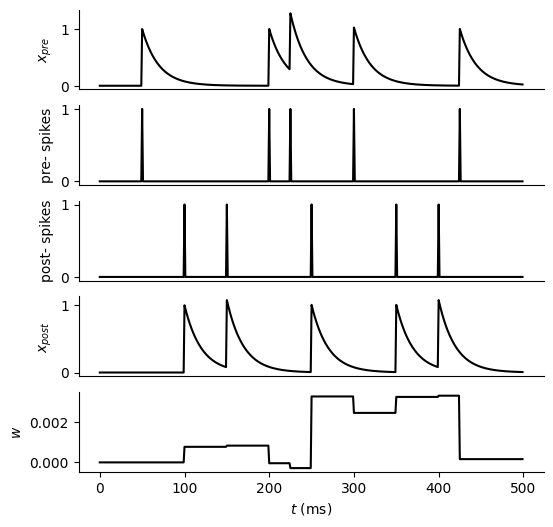

In [2]:
# Online STDP

#定数
dt = 1e-3 #sec
T = 0.5 #sec
nt = round(T/dt)
tau_p = tau_m = 2e-2 #ms
A_p = 0.01; A_m = 1.05*A_p

#pre/postsynaptic spikes
spike_pre = np.zeros(nt); spike_pre[[50, 200, 225, 300, 425]] = 1
spike_post = np.zeros(nt); spike_post[[100, 150, 250, 350, 400]] = 1

#記録用配列
x_pre_arr = np.zeros(nt); x_post_arr = np.zeros(nt)
w_arr = np.zeros(nt)

#初期化
x_pre = x_post = 0 # pre/post synaptic trace
w = 0 # synaptic weight
#Online STDP
for t in range(nt):
    x_pre = x_pre*(1-dt/tau_p) + spike_pre[t]
    x_post = x_post*(1-dt/tau_m) + spike_post[t]
    dw = A_p*x_pre*spike_post[t] - A_m*x_post*spike_pre[t]
    w += dw #重みの更新
    x_pre_arr[t] = x_pre
    x_post_arr[t] = x_post
    w_arr[t] = w

# 描画
time = np.arange(nt)*dt*1e3
def hide_ticks(): #上と右の軸を表示しないための関数
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')

plt.figure(figsize=(6, 6))
plt.subplot(5,1,1)
plt.plot(time, x_pre_arr, color="k")
plt.ylabel("$x_{pre}$"); hide_ticks(); plt.xticks([])
plt.subplot(5,1,2)
plt.plot(time, spike_pre, color="k")
plt.ylabel("pre- spikes"); hide_ticks(); plt.xticks([])
plt.subplot(5,1,3)
plt.plot(time, spike_post, color="k")
plt.ylabel("post- spikes"); hide_ticks(); plt.xticks([])
plt.subplot(5,1,4)
plt.plot(time, x_post_arr, color="k")
plt.ylabel("$x_{post}$"); hide_ticks(); plt.xticks([])
plt.subplot(5,1,5)
plt.plot(time, w_arr, color="k")
plt.xlabel("$t$ (ms)"); plt.ylabel("$w$"); hide_ticks()
plt.show()

在线 STDP 规则：（第 1 行）突触前细胞的峰值轨迹（第 2 行）突触前细胞的峰值轨迹（第 3 行）突触后细胞的峰值轨迹（第 4 行）突触后细胞的峰值轨迹（第 5 行）权重变化（默认值 0）

使用矩阵的STDP实现

突触前后细胞分别为 $N_{pre}$, $N_{post}$

$\bold s(t)$: spike发生时为1，其余情况为0。

$\bold W$: $\mathbb R^{N_{pre}}\times \mathbb R^{N_{post}}$

$\bold s^{pre}\in \mathbb R^{N_{pre}}$,$\bold s^{post}\in \mathbb R^{N_{post}}$

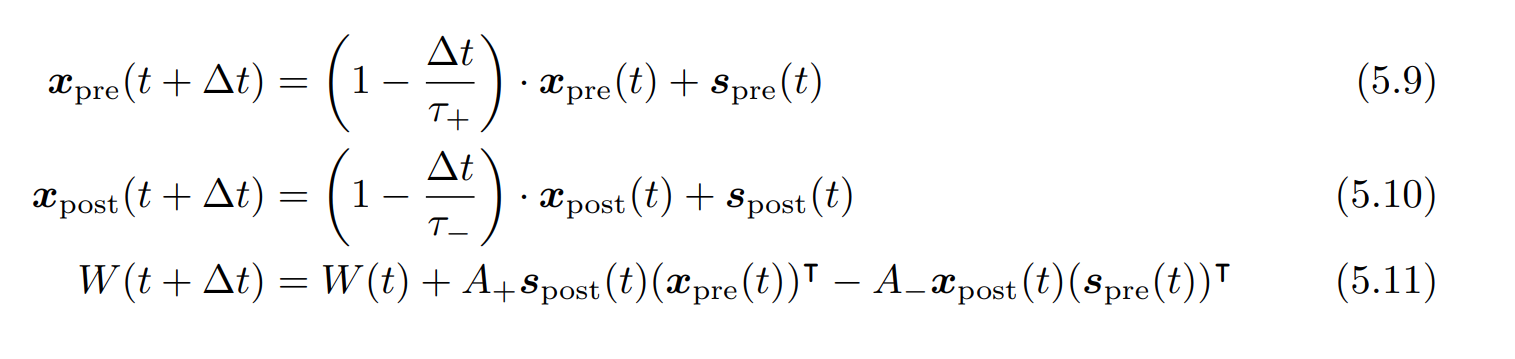

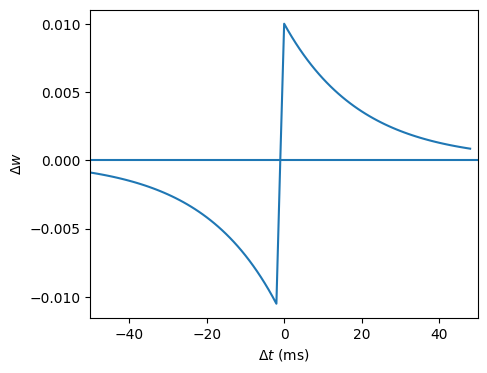

In [4]:
import numpy as np
import matplotlib.pyplot as plt
dt = 1e-3; T = 5e-2 #sec
nt = round(T/dt)
N_pre = nt; N_post = 2
tau_p = tau_m = 2e-2 #ms
A_p = 0.01; A_m = 1.05*A_p
# pre/postsynaptic spikes
spike_pre = np.eye(N_pre) #単位行列で dt ごとに発火するニューロンを N 個作成
spike_post = np.zeros((N_post, nt))
spike_post[0, -1] = spike_post[1, 0] = 1
# 初期化
x_pre = np.zeros(N_pre)
x_post = np.zeros(N_post)
W = np.zeros((N_post, N_pre))
for t in range(nt):
    # 1 次元配列 -> 縦ベクトル or 横ベクトル
    spike_pre_ = np.expand_dims(spike_pre[:, t], 0) # (1, N)
    spike_post_ = np.expand_dims(spike_post[:, t], 1) # (2, 1)
    x_pre_ = np.expand_dims(x_pre, 0) # (1, N)
    x_post_ = np.expand_dims(x_post, 1) # (2, 1)
    # Online STDP
    dW = A_p*np.matmul(spike_post_, x_pre_)
    dW -= A_m*np.matmul(x_post_, spike_pre_)
    W += dW
    # Update
    x_pre = x_pre*(1-dt/tau_p) + spike_pre[:, t]
    x_post = x_post*(1-dt/tau_m) + spike_post[:, t]
    # 結果
    delta_w = np.zeros(nt*2-1) # スパイク時間差 = 0ms が重複
    delta_w[:nt] = W[0, :]; delta_w[nt:] = W[1, 1:]

# 結果
delta_w = np.zeros(nt*2-1) # スパイク時間差 = 0ms が重複
delta_w[:nt] = W[0, :]; delta_w[nt:] = W[1, 1:]
# 描画
time = np.arange(-T, T-dt, dt)*1e3
plt.figure(figsize=(5, 4))
plt.plot(time, delta_w[::-1])
plt.hlines(0, -50, 50)
plt.xlabel("$\Delta t$ (ms)")
plt.ylabel("$\Delta w$")
plt.xlim(-50, 50)
plt.show()



### 5.1.3 权重依存的STDP

生理学上存在突触强度$w_{min} < w < w_{max}$的限制(bound)。

许多情况下，$w_{min} = 0$。

以下以$w\in [0,w_{max}]$的情况考虑。

同时在以下，$A_\pm$为与权重依存的函数$A_\pm(w)$

【软限制】
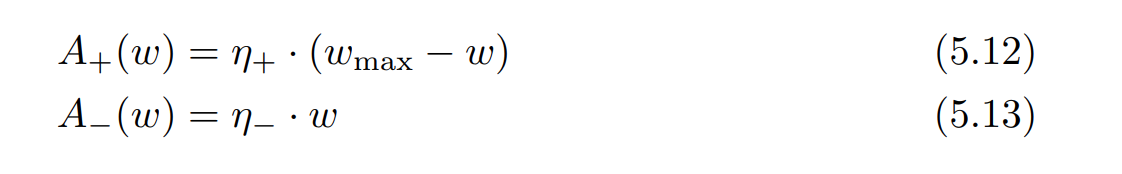

【硬限制】
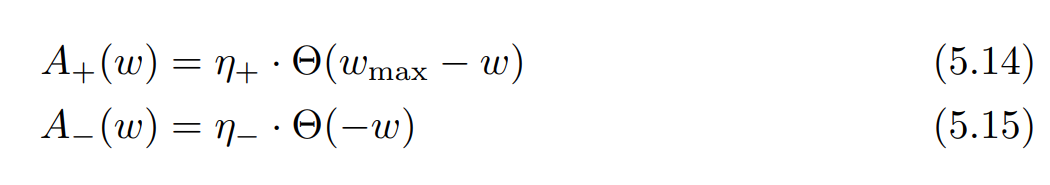

其中$\Theta(x)$ 为阶段函数。$x<0$时为0，其余情况为1。

## 5.2 STDP学习则以及基于WTA网络的无监督学习

**WTA (Winner-take-all)**令神经网络内的神经元相互抑制。
发火率最高的神经元以外的神经元被抑制，不进行发火。

WTA这样结构的学习被称为 **竞争学习(Competitive Learning)**

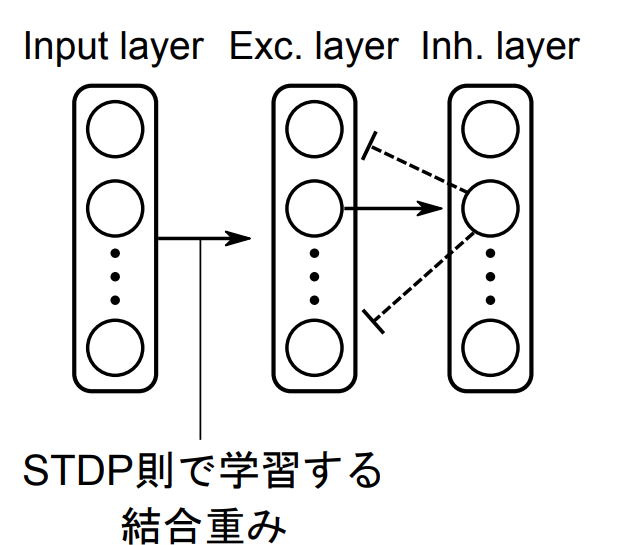

Diehl提出了在MNIST数据集上应用的双层SNN。

第一层为输入层（Size = 28 * 28）, MNIST数据集的画像中，1像素对应1神经元。同时进行Poission过程模型编码。

第二层由兴奋性神经元以及抑制性神经元构成（两类神经元的数量相等）。

一个兴奋性神经元投射到一个抑制性神经元。

抑制性神经元抑制除了给予其输入的神经元外的所有其他兴奋性神经元。

### 5.2.1 神经元与突触模型

神经元与突触模型使用 Conductance-based 的模型。

【神经元模型】

$$\tau\frac{dV}{dt}=(E_{rest} - V) + g_e(E_{exe}-V) + g_i(E_{inh}-V)$$

这与通常基于电导的模型中的公式相同。
但为了保持网络的发射率不变，

假定兴奋神经元膜电位的发射阈值在每次发射时增加 $θ = 0.05 mV$。

在没有发射的情况下，其以 $10^7$ 毫秒的时间常数衰减。

在作者的实现过程中，图像编码的尖峰序列输入时间为 350 毫秒，并设置了 150 毫秒的空白期用于重置变量。在此期间，**所有膜电位都会重置**，但只有**发射阈值会仅衰减**。

此外，若兴奋性神经元的发射数量较少，则会增加输入泊松尖峰的发射率，并再次呈现相同的图像。

兴奋性神经元膜电位的**时间常数**被用作 100 毫秒的生理偏差值。

据解释，较大的时间常数可以整合大量的尖峰输入，并减少噪声的影响。

【突触模型】

这种突触是Conductance-based的single exponentialsynapse。当尖峰进入时，电导 $g$ 增加 $w$，否则以如下形式衰减：

$$\tau_x \frac{dg_x}{dt} = -g_x$$

5.2.2 兴奋性神经元Labeling

该网络**没有输出层**，以一种不同寻常的方式对图像进行分类。

首先，在训练过程中**记录兴奋神经元的所有活动**。

之后，利用图像上的原始标签，计算出各个兴奋神经元在图像上每种标签的平均触发次数。

找出每个神经元跃迁次数最多的标签，并将此标签分配给每个神经元。

之后利用分配的标签，对于输入图像计算各个分配了标签的神经元的平均发火数。

此时平均发火率最高的神经元群的标签为预测标签。

In [2]:
def assign_labels(spikes, labels, n_labels, rates=None, alpha=1.0):
    n_neurons = spikes.shape[1]
    if rates is None:
        rates = np.zeros((n_neurons, n_labels)).astype(np.float32)
    
    # 時間の軸でスパイク数の和を取る
    for i in range(n_labels):
        # サンプル内の同じラベルの数を求める
        n_labeled = np.sum(labels == i).astype(np.int16)
        
        if n_labeled > 0:
            # label == i のサンプルのインデックスを取得
            indices = np.where(labels == i)[0]
            # label == i に対する各ニューロンごとの平均発火率を計算
            #(前回の発火率との移動平均)
            rates[:, i] = alpha * rates[:, i] + (np.sum(spikes[indices], axis=0)/n_labeled)
    
    sum_rate = np.sum(rates, axis=1)
    sum_rate[sum_rate == 0] = 1
    
    # クラスごとの発火頻度の割合を計算する
    proportions = rates / np.expand_dims(sum_rate, 1) # (n_neurons, n_labels)
    proportions[proportions != proportions] = 0 # Set NaNs to 0
    
    # 最も発火率が高いラベルを各ニューロンに割り当てる (n_neurons,)
    assignments = np.argmax(proportions, axis=1).astype(np.uint8)
    return assignments, proportions, rates


其中，assignments 是一个大小为（n 个神经元）的数组，代表分配给每个神经元的标签。利用这个数组，我们可以实现预测函数，预测每个样本的标签。

In [3]:
def prediction(spikes, assignments, n_labels):
    n_samples = spikes.shape[0]
    # 各サンプルについて各ラベルの発火率を見る
    rates = np.zeros((n_samples, n_labels)).astype(np.float32)
    for i in range(n_labels):
        # 各ラベルが振り分けられたニューロンの数
        n_assigns = np.sum(assignments == i).astype(np.uint8)
        if n_assigns > 0:
            # 各ラベルのニューロンのインデックスを取得
            indices = np.where(assignments == i)[0]
            # 各ラベルのニューロンのレイヤー全体における平均発火数を求める
            rates[:, i] = np.sum(spikes[:, indices], axis=1) / n_assigns
            # レイヤーの平均発火率が最も高いラベルを出力
            
    return np.argmax(rates, axis=1).astype(np.uint8) # (n_samples, )


预测需要三个参数：峰值、赋值和 n 个标签。每个参数都与前面描述的同名数组相同。然后计算与每个标签相关联的每个神经元的平均跃迁次数，并将平均跃迁次数最高的标签作为输入样本的标签

### 5.2.3 将MNIST数据集変換为Spike列


编写一个函数，将 MNIST 数据集转换为尖峰序列作为输入。您可以编写一个单独的函数来读取 MNIST 数据集，但这将过于复杂，因此我们将使用 ANN 库中包含的数据读取函数。在此，我们以 Chainer 的 chainer.datasets.get mnist() 为例，但也可以使用其他库，无需进行重大修改。

In [4]:
def online_load_and_encoding_dataset(dataset, i, dt, n_time, max_fr=32,
norm=140):
    fr_tmp = max_fr*norm/np.sum(dataset[i][0])
    fr = fr_tmp*np.repeat(np.expand_dims(dataset[i][0],
    axis=0), n_time, axis=0)
    input_spikes = np.where(np.random.rand(n_time, 784) < fr*dt, 1, 0)
    input_spikes = input_spikes.astype(np.uint8)
    return input_spikes



在此，将进行归一化处理，使每个输入中的尖峰数量相等。使用该函数的示例以及检查尖峰序列转换是否正确的代码如下所示。

In [7]:
!pip install chainer

  Using cached chainer-7.8.1.tar.gz (1.0 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967725 sha256=6bd95d97715f84d163e60487362a59ac74f21e8d83474220588c355caf4fa064
  Stored in directory: c:\users\micro\appdata\local\pip\cache\wheels\e6\ac\28\238b241657bc839abccb7d8046f474d8cddb56da9bc4266add
Successfully built chainer


In [8]:
import chainer
dt = 1e-3; t_inj = 0.350; nt_inj = round(t_inj/dt)
train, _ = chainer.datasets.get_mnist() # Chainer による MNIST データの読み込み
input_spikes = online_load_and_encoding_dataset(dataset=train, i=0,
dt=dt, n_time=nt_inj)
# 描画
plt.imshow(np.reshape(np.sum(input_spikes, axis=0), (28, 28)), cmap="gray")
plt.show()


NameError: name 'np' is not defined

在时间上对spike进行加法，即可得到图像。

### 5.2.4 网络构建


In [19]:
class ConductanceBasedLIF:
    def __init__(self, N, dt=1e-4, tref=5e-3, tc_m=1e-2,
    vrest=-60, vreset=-60, vthr=-50, vpeak=20,
    e_exc=0, e_inh=-100):
        self.N = N
        self.dt = dt
        self.tref = tref
        self.tc_m = tc_m
        self.vrest = vrest
        self.vreset = vreset
        self.vthr = vthr
        self.vpeak = vpeak
        self.e_exc = e_exc # 興奮性シナプスの平衡電位
        self.e_inh = e_inh # 抑制性シナプスの平衡電位
        self.v = self.vreset*np.ones(N)
        self.v_ = None
        self.tlast = 0
        self.tcount = 0
        
    def initialize_states(self, random_state=False):
            if random_state:
                self.v = self.vreset + np.random.rand(self.N)*(self.vthr-self.vreset)
            else:
                self.v = self.vreset*np.ones(self.N)
            self.tlast = 0
            self.tcount = 0
                
    def __call__(self, g_exc, g_inh):
            I_synExc = g_exc*(self.e_exc - self.v) # 興奮性入力
            I_synInh = g_inh*(self.e_inh - self.v) # 抑制性入力
            dv = (self.vrest - self.v + I_synExc + I_synInh) / self.tc_m
            v = self.v+((self.dt*self.tcount)>(self.tlast+self.tref))*dv*self.dt
            
            s = 1*(v>=self.vthr) # 発火時は 1, その他は 0 の出力
            
            self.tlast = self.tlast*(1-s) + self.dt*self.tcount*s # 発火時刻の更新
            v = v*(1-s) + self.vpeak*s # 閾値を超えると膜電位を vpeak にする
            self.v_ = v # 発火時の電位も含めて記録するための変数
            self.v = v*(1-s) + self.vreset*s # 発火時に膜電位をリセット
            self.tcount += 1
            
            return s


In [16]:
from Models.Connections import FullConnection, DelayConnection
from Models.Neurons import DiehlAndCook2015LIF, CurrentBasedLIF
from Models.Synapses import SingleExponentialSynapse

class DiehlAndCook2015Network:

    def __init__(self, n_in=784, n_neurons=100, wexc=2.25, winh=0.85,
    dt=1e-3, wmin=0.0, wmax=5e-2, lr=(1e-2, 1e-4),
    update_nt=100):
        self.dt = dt
        self.lr_p, self.lr_m = lr
        self.wmax = wmax
        self.wmin = wmin
        self.n_neurons = n_neurons
        self.n_in = n_in
        self.norm = 0.1
        self.update_nt = update_nt

        # Neurons
        self.exc_neurons = DiehlAndCook2015LIF(n_neurons, dt=dt, tref=5e-3,
        tc_m=1e-1, vrest=-65,
        vreset=-65, init_vthr=-52,
        vpeak=20, theta_plus=0.05,
        theta_max=35, tc_theta=1e4,
        e_exc=0, e_inh=-100)
        
        self.inh_neurons = ConductanceBasedLIF(n_neurons, dt=dt, tref=2e-3,
        tc_m=1e-2, vrest=-60,
        vreset=-45,
        vthr=-40, vpeak=20,
        e_exc=0, e_inh=-85)

        # Synapses
        self.input_synapse = SingleExponentialSynapse(n_in, dt=dt, td=1e-3)
        self.exc_synapse = SingleExponentialSynapse(n_neurons, dt=dt, td=1e-3)
        self.inh_synapse = SingleExponentialSynapse(n_neurons, dt=dt, td=2e-3)
        self.input_synaptictrace = SingleExponentialSynapse(n_in, dt=dt,
        td=2e-2)
        self.exc_synaptictrace = SingleExponentialSynapse(n_neurons, dt=dt,
        td=2e-2)

        # Connections (重みの初期化)
        initW = 1e-3*np.random.rand(n_neurons, n_in)
        self.input_conn = FullConnection(n_in, n_neurons, initW=initW)
        self.exc2inh_W = wexc*np.eye(n_neurons)
        self.inh2exc_W = (winh/n_neurons)*(np.ones((n_neurons, n_neurons)) \
        - np.eye(n_neurons))
        self.delay_input = DelayConnection(N=n_neurons, delay=5e-3, dt=dt)
        self.delay_exc2inh = DelayConnection(N=n_neurons, delay=2e-3, dt=dt)

        self.g_inh = np.zeros(n_neurons)

        self.tcount = 0
        
        self.s_in_ = np.zeros((self.update_nt, n_in))
        self.s_exc_ = np.zeros((n_neurons, self.update_nt))
        self.x_in_ = np.zeros((self.update_nt, n_in))
        self.x_exc_ = np.zeros((n_neurons, self.update_nt))

    # スパイクトレースのリセット
    def reset_trace(self):
        self.s_in_ = np.zeros((self.update_nt, self.n_in))
        self.s_exc_ = np.zeros((self.n_neurons, self.update_nt))
        self.x_in_ = np.zeros((self.update_nt, self.n_in))
        self.x_exc_ = np.zeros((self.n_neurons, self.update_nt))
        self.tcount = 0

    # 状態の初期化
    def initialize_states(self):
        self.exc_neurons.initialize_states()
        self.inh_neurons.initialize_states()
        self.delay_input.initialize_states()
        self.delay_exc2inh.initialize_states()
        self.input_synapse.initialize_states()
        self.exc_synapse.initialize_states()
        self.inh_synapse.initialize_states()
    
    def __call__(self, s_in, stdp=True):
        # 入力層
        c_in = self.input_synapse(s_in)
        x_in = self.input_synaptictrace(s_in)
        g_in = self.input_conn(c_in)

        # 興奮性ニューロン層
        s_exc = self.exc_neurons(self.delay_input(g_in), self.g_inh)
        c_exc = self.exc_synapse(s_exc)
        g_exc = np.dot(self.exc2inh_W, c_exc)
        x_exc = self.exc_synaptictrace(s_exc)
        # 抑制性ニューロン層
        s_inh = self.inh_neurons(self.delay_exc2inh(g_exc), 0)
        c_inh = self.inh_synapse(s_inh)
        self.g_inh = np.dot(self.inh2exc_W, c_inh)

        if stdp:
            # スパイク列とスパイクトレースを記録
            self.s_in_[self.tcount] = s_in
            self.s_exc_[:, self.tcount] = s_exc
            self.x_in_[self.tcount] = x_in
            self.x_exc_[:, self.tcount] = x_exc
            self.tcount += 1
            # Online STDP
            if self.tcount == self.update_nt:
                W = np.copy(self.input_conn.W)
                # post に投射される重みが均一になるようにする
                W_abs_sum = np.expand_dims(np.sum(np.abs(W), axis=1), 1)
                W_abs_sum[W_abs_sum == 0] = 1.0
                W *= self.norm / W_abs_sum
                # STDP 則
                dW = self.lr_p*(self.wmax-W)*np.dot(self.s_exc_, self.x_in_)
                dW -= self.lr_m*W*np.dot(self.x_exc_, self.s_in_)
                clipped_dW = np.clip(dW / self.update_nt, -1e-3, 1e-3)
                self.input_conn.W = np.clip(W + clipped_dW,self.wmin, self.wmax)
                self.reset_trace() # スパイク列とスパイクトレースをリセット
        return s_exc







### 5.2.5 STDP法则的学习法结果表示


下文将介绍实际模拟情况。时间步长设置为 1 毫秒。
时间步长为 1 ms，其中 350 ms 输入经过图像转换的尖峰序列，150 ms 不输入。
时间步长设置为 1 毫秒。兴奋神经元和抑制神经元的数量设为 100，即训练数据的样本数。
兴奋神经元和抑制神经元的数量设为 100 个，训练数据样本数设为 10000 个，epochs 数设为 30 个。
为了在训练后对网络进行评估，需要调用该文件中的函数。
网络将在训练后进行评估。因此，如果 name == ' main ': 这部分内容应写在说明中，以免从外部调用。
这样就不会被外部调用。

这里的call（）函数有两个参数值：输入尖峰序列 s in 和表示是否使用 STDP 规则训练的布尔变量 stdp。当 stdp 为真时，将记录输入神经元层和兴奋神经元层的尖峰序列和尖峰轨迹，并在 self.tcount 变成 self.update nt 时根据 STDP 规则更新权重。在更新权重之前，先对权重进行归一化处理，使投射到兴奋神经元的权重之和为 self.norm。STDP 规则假定与权重有关。权重受 np.clip() 的限制，因此在更新权重时，权重应在 self.wmin 和 self.wmax 范围内。

In [25]:
import os
from tqdm import tqdm
import numpy as np
# 350ms 画像入力, 150ms 入力なしでリセットさせる (膜電位の閾値以外)
dt = 1e-3 # タイムステップ (sec)
t_inj = 0.350 # 刺激入力時間 (sec)
t_blank = 0.150 # ブランク時間 (sec)
nt_inj = round(t_inj/dt)
nt_blank = round(t_blank/dt)
n_neurons = 100 # 興奮性/抑制性ニューロンの数
n_labels = 10 # ラベル数
n_epoch = 2 # エポック数
n_train = 1000 # 10000 # 訓練データの数
update_nt = nt_inj # STDP 則による重みの更新間隔
# Chainer による MNIST データの読み込み
train, _ = chainer.datasets.get_mnist()
labels = np.array([train[i][1] for i in range(n_train)]) # ラベルの配列
# ネットワークの定義
network = DiehlAndCook2015Network(n_in=784, n_neurons=n_neurons,
wexc=2.25, winh=0.85,
dt=dt, wmin=0.0, wmax=2e-5,
lr=(1e-2, 1e-4),
update_nt=update_nt)
network.initialize_states() # ネットワークの初期化
spikes = np.zeros((n_train, n_neurons)).astype(np.uint8) # スパイク記録変数
accuracy_all = np.zeros(n_epoch) # 訓練精度を記録する変数
blank_input = np.zeros(784) # ブランク入力
init_max_fr = 32 # 初期のポアソンスパイクの最大発火率
# 結果を保存するディレクトリ
results_save_dir = "./LIF_WTA_STDP_MNIST_results/"
os.makedirs(results_save_dir, exist_ok=True) # ディレクトリが無ければ作成

# Simulation
for epoch in range(n_epoch):
    for i in tqdm(range(n_train)):
        max_fr = init_max_fr
        while(True):
            # 入力スパイクをオンラインで生成
            input_spikes = online_load_and_encoding_dataset(train, i, dt,nt_inj,max_fr)
            spike_list = [] # サンプルごとにスパイクを記録するリスト
            # 画像刺激の入力
            for t in range(nt_inj):
                s_exc = network(input_spikes[t], stdp=True)
                spike_list.append(s_exc)
            
            # スパイク数を記録
            spikes[i] = np.sum(np.array(spike_list), axis=0)
            # ブランク刺激の入力
            for _ in range(nt_blank):
                _ = network(blank_input, stdp=False)

            # スパイク数を計算
            num_spikes_exc = np.sum(np.array(spike_list))

            # スパイク数が 5 より大きければ次のサンプルへ
            if num_spikes_exc >= 5:
                break
            else: # スパイク数が 5 より小さければ入力発火率を上げて再度刺激
                max_fr += 16

    # ニューロンを各ラベルに割り当てる
    if epoch == 0:
        assignments, proportions, rates = assign_labels(spikes, labels,n_labels)
    else:
        assignments, proportions, rates = assign_labels(spikes, labels,n_labels, rates)
    
    print("Assignments:\n", assignments)

    # スパイク数の確認 (正常に発火しているか確認)
    sum_nspikes = np.sum(spikes, axis=1)
    mean_nspikes = np.mean(sum_nspikes).astype(np.float16)
    print("Ave. spikes:", mean_nspikes)
    print("Min. spikes:", sum_nspikes.min())
    print("Max. spikes:", sum_nspikes.max())

    # 入力サンプルのラベルを予測する
    predicted_labels = prediction(spikes, assignments, n_labels)
    # 訓練精度を計算
    accuracy = np.mean(np.where(labels==predicted_labels, 1, 0))
    print("epoch :", epoch, " accuracy :", accuracy)
    accuracy_all[epoch] = accuracy
    # 学習率の減衰
    network.lr_p *= 0.75
    network.lr_m *= 0.75
    # 重みの保存 (エポック毎)
    np.save(results_save_dir+"weight_epoch"+str(epoch)+".npy",network.input_conn.W)

# 結果
plt.figure(figsize=(5,4))
plt.plot(np.arange(1, n_epoch+1), accuracy_all*100,
color="k")
plt.xlabel("Epoch")
plt.ylabel("Train accuracy (%)")
plt.savefig(results_save_dir+"accuracy.png")
# パラメータの保存
np.save(results_save_dir+"assignments.npy", assignments)
np.save(results_save_dir+"weight.npy", network.input_conn.W)
np.save(results_save_dir+"exc_neurons_theta.npy",
network.exc_neurons.theta)



  0%|          | 4/1000 [00:05<24:31,  1.48s/it]

### 5.2.6 以测试数据评价

In [2]:
import chainer
from LIF_WTA_STDP_MNIST import online_load_and_encoding_dataset, prediction
from LIF_WTA_STDP_MNIST import DiehlAndCook2015Network

# 350ms 画像入力, 150ms 入力なしでリセットさせる (膜電位の閾値以外)
dt = 1e-3 # タイムステップ (sec)
t_inj = 0.350 # 刺激入力時間 (sec)
t_blank = 0.150 # ブランク時間 (sec)

nt_inj = round(t_inj/dt)
nt_blank = round(t_blank/dt)
n_neurons = 100 #興奮性/抑制性ニューロンの数
n_labels = 10 #ラベル数
n_train = 1000 # 訓練データの数
update_nt = nt_inj # STDP 則による重みの更新間隔
_, test = chainer.datasets.get_mnist() # Chainer による MNIST データの読み込み
labels = np.array([test[i][1] for i in range(n_train)]) # ラベルの配列

# 結果が保存されているディレクトリ
results_save_dir = "./LIF_WTA_STDP_MNIST_results/"

# ネットワークの定義
network = DiehlAndCook2015Network(n_in=784, n_neurons=n_neurons,
wexc=2.25, winh=0.85, dt=dt)
network.initialize_states() # ネットワークの初期化

# 重みと閾値の load
network.input_conn.W = np.load(results_save_dir+"weight.npy")
network.exc_neurons.theta = np.load(results_save_dir+"exc_neurons_theta.npy")
network.exc_neurons.theta_plus = 0 # 閾値が上昇しないようにする

#スパイクを記録する変数
spikes = np.zeros((n_train, n_neurons)).astype(np.uint8)
blank_input = np.zeros(784) # ブランク入力
init_max_fr = 32 # 初期のポアソンスパイクの最大発火率

for i in tqdm(range(n_train)):
    max_fr = init_max_fr
    while(True):
        # 入力スパイクをオンラインで生成
        input_spikes = online_load_and_encoding_dataset(test, i, dt, nt_inj, max_fr)
        
        spike_list = [] # サンプルごとにスパイクを記録するリスト
        # 画像刺激の入力
        for t in range(nt_inj):
            s_exc = network(input_spikes[t], stdp=False)
            spike_list.append(s_exc)
        
        spikes[i] = np.sum(np.array(spike_list), axis=0) # スパイク数を記録

        # ブランク刺激の入力
        for _ in range(nt_blank):
            _ = network(blank_input, stdp=False)

        num_spikes_exc = np.sum(np.array(spike_list)) # スパイク数を計算
        if num_spikes_exc >= 5: # スパイク数が 5 より大きければ次のサンプルへ
            break
        else: # スパイク数が 5 より小さければ入力発火率を上げて再度刺激
            max_fr += 16

# 入力サンプルのラベルを予測する
assignments = np.load(results_save_dir+"assignments.npy")
predicted_labels = prediction(spikes, assignments, n_labels)

# 訓練精度を計算
accuracy = np.mean(np.where(labels==predicted_labels, 1, 0))
print("Test accuracy :", accuracy)


ModuleNotFoundError: No module named 'LIF_WTA_STDP_MNIST'

### 5.2.7 兴奋性神经元受容野描画

最后，让我们画出学习后从输入层到兴奋神经元层的突触权重。. 我们要做的就是将投射到每个兴奋神经元的 784 个突触权重重塑为 28×28 并绘制出来。
我们要做的就是将投射到每个兴奋神经元的 784 个突触权重重塑为 28×28 并绘制出来。

In [4]:
import numpy as np

epoch = 29
n_neurons = 100

# 結果が保存されているディレクトリ
results_save_dir = "./LIF_WTA_STDP_MNIST_results/"
input_conn_W = np.load(results_save_dir+"weight_epoch"+str(epoch)+".npy")
reshaped_W = np.reshape(input_conn_W, (n_neurons, 28, 28))

# 描画
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1,
                hspace=0.05, wspace=0.05)
row = col = np.sqrt(n_neurons)
for i in tqdm(range(n_neurons)):
    ax = fig.add_subplot(row, col, i+1, xticks=[], yticks=[])
    ax.imshow(reshaped_W[i], cmap="gray")
plt.savefig("weights_"+str(epoch)+".png")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './LIF_WTA_STDP_MNIST_results/weight_epoch29.npy'